In [11]:
# import bibliotek i inicjacja danych, funkcji

from matplotlib import pylab as plt
from skimage.filters import frangi
import numpy as np 
import cv2

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.utils import to_categorical

ground_truth_paths = ['datasets/hrf/labeled/01_h.tif',
                      'datasets/hrf/labeled/02_h.tif',
                      'datasets/hrf/labeled/03_h.tif',
                      'datasets/hrf/labeled/04_h.tif',
                      'datasets/hrf/labeled/05_h.tif',
                      'datasets/hrf/labeled/06_h.tif',
                      'datasets/hrf/labeled/07_h.tif',
                      'datasets/hrf/labeled/08_h.tif',
                      'datasets/hrf/labeled/09_h.tif',
                      'datasets/hrf/labeled/10_h.tif',                      
                      'datasets/hrf/labeled/11_h.tif',
                      'datasets/hrf/labeled/12_h.tif',
                      'datasets/hrf/labeled/13_h.tif',
                      'datasets/hrf/labeled/14_h.tif',
                      'datasets/hrf/labeled/15_h.tif'
                     ]
img_paths = ['datasets/hrf/01_h.jpg', 
             'datasets/hrf/02_h.jpg',
             'datasets/hrf/03_h.jpg',
             'datasets/hrf/04_h.jpg',
             'datasets/hrf/05_h.jpg',
             'datasets/hrf/06_h.jpg',
             'datasets/hrf/07_h.jpg',
             'datasets/hrf/08_h.jpg',
             'datasets/hrf/09_h.jpg',
             'datasets/hrf/10_h.jpg',             
             'datasets/hrf/11_h.jpg',
             'datasets/hrf/12_h.jpg',
             'datasets/hrf/13_h.jpg',
             'datasets/hrf/14_h.jpg',
             'datasets/hrf/15_h.jpg'
            ]

img_samples_size = 5
sampling_percentage = 0.2
resize_image_coeff = 0.25

def getImageValuesAsModelData(image, ground_truth_image, samples_size, sampling_percentage):
    # array of sampled images
    dataset_x = []

    # tablica zawierająca informację o występowaniu naczynia krwionośnego; 1 - występuje
    dataset_y = []
    for k in range(len(image)):
        height, width, depth = image[k].shape

        for i in range(0, height - samples_size):  
            for j in np.floor(np.arange(0, width - samples_size, 1/sampling_percentage)).astype(int):
                arr_sample = image[k][i : i + samples_size, j : j + samples_size]
                dataset_x.append(np.array(arr_sample))

                # dodaj informację o wykrytym naczyniu do dataset_y
                arr_ground_sample = ground_truth_image[k][i : i + samples_size, j : j + samples_size]
                point_y = arr_ground_sample[samples_size // 2][samples_size // 2]
                point_mean = np.mean(point_y)

                if point_mean > 50:
                    dataset_y.append(1)
                else:
                    dataset_y.append(0)
                
    dataset_x = np.array(dataset_x)
    dataset_x = dataset_x.reshape(len(dataset_x), samples_size, samples_size,3)
    
    dataset_y = to_categorical(dataset_y)
    
    return dataset_x, dataset_y

def readImage(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (0,0), fx=resize_image_coeff, fy=resize_image_coeff) 
    
    return img
    
def showPredictedImage(prediction, width, height):
    new_img = []

    for i in range(0, height - img_samples_size):  
        row = []
        for j in range(0, width - img_samples_size):
            index = (width - img_samples_size) * i + j
            if(prediction[index][0] < prediction[index][1]):
                row.append(1)
            else:
                row.append(0)

        new_img.append(np.array(row))

    new_img = np.array(new_img)
    plt.imshow(new_img, cmap="gray")

In [12]:
def countMetrics(data, pred):
    positive_all = 0
    negative_all = 0
    positive_true = 0
    negative_true = 0
    positive_false = 0
    negative_false = 0

    # zmierz metryki
    for i in range(len(pred)):
        # jeśli tło
        if(data[i][0] > data[i][1]):
            positive_all +=1
            if(pred[i][0] > pred[i][1]):
                positive_true +=1
            else:
                positive_false +=1
        # jeśli naczynie
        else:
            negative_all +=1
            if(pred[i][0] < pred[i][1]):
                negative_true +=1
            else:
                negative_false +=1

    acc = (positive_true + negative_true)/(positive_all + negative_all)

    sen = positive_true / (positive_true + negative_false)
    spec = negative_true / (negative_true + positive_false)

    neg = negative_true / (negative_true + negative_false)
    prec = positive_true / (positive_true + positive_false)
    
    return acc, sen, spec, neg, prec

In [19]:
# wybierz dane do testowania
images = []
ground_truths = []

for i in range(3):
    images.append(readImage(img_paths[i]))
    ground_truths.append(readImage(ground_truth_paths[i]))

data_x, data_y = getImageValuesAsModelData(images, ground_truths, img_samples_size, 1)

In [26]:
# k-krotna walidacja skośna
k = 0
avg_accuracy = avg_sensitivity = avg_specificity = avg_negative = avg_precision = 0

kf = KFold(n_splits=10, random_state=42, shuffle=True)
for train_index, test_index in kf.split(data_x):

    X_train, X_test, y_train, y_test = data_x[train_index], data_x[test_index], data_y[train_index], data_y[test_index]
    
    model = Sequential()

    model.add(Conv2D(75, kernel_size=3, activation='relu', input_shape=(5,5,3)))
    model.add(Conv2D(45, kernel_size=3, activation='relu'))
    model.add(Flatten())
    model.add(Dense(2, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2)
    
    prediction = model.predict(X_test)

    acc, sen, spec, neg, prec = countMetrics(y_test, prediction)
    
    avg_accuracy += acc
    avg_sensitivity += sen
    avg_specificity += spec
    avg_negative += neg
    avg_precision += prec
    
    print("--------" + " Wyniki dla zbioru nr " + str(k) + " --------")
    print("Accuracy: " + str(acc))

    print("Sensitivity: " + str(sen))
    print("Specificity: " + str(spec))

    print("Negative predictive value: " + str(neg))    
    print("Precision: " + str(prec))

    k += 1

print("Średnie wyniki dla tego rozwiązania")
print("średnie accuracy: " + str(avg_accuracy/k))
print("średnie sensitivity: " + str(avg_sensitivity/k))
print("średnie specificity: " + str(avg_specificity/k))
print("średnie negative predictive value: " + str(avg_negative/k))
print("średnie precision: " + str(avg_precision/k))

Train on 453878 samples, validate on 50431 samples
Epoch 1/2
453878/453878 [==============================] - 31s 68us/step - loss: 0.1653 - accuracy: 0.9517 - val_loss: 0.1427 - val_accuracy: 0.9541
Epoch 2/2
453878/453878 [==============================] - 32s 70us/step - loss: 0.1234 - accuracy: 0.9596 - val_loss: 0.1093 - val_accuracy: 0.9629
-------- Wyniki dla zbioru nr 0 --------
Accuracy: 0.9628998036921734
Sensitivity: 0.9660004643015427
Specificity: 0.9146981627296588
Negative predictive value: 0.6337804046374176
Precision: 0.9943517553006604
Train on 453878 samples, validate on 50431 samples
Epoch 1/2
453878/453878 [==============================] - 31s 68us/step - loss: 0.1586 - accuracy: 0.9532 - val_loss: 0.1243 - val_accuracy: 0.9556
Epoch 2/2
453878/453878 [==============================] - 30s 67us/step - loss: 0.1111 - accuracy: 0.9635 - val_loss: 0.1050 - val_accuracy: 0.9642
-------- Wyniki dla zbioru nr 1 --------
Accuracy: 0.9641886934623545
Sensitivity: 0.9692107

In [24]:
# wytrenowanie finalnego modelu

model = Sequential()

model.add(Conv2D(70, kernel_size=3, activation='relu', input_shape=(5,5,3)))
model.add(Conv2D(45, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# wytrenuj model
train_data, test_data, train_labels, test_labels = train_test_split(data_x, 
                                                                    data_y, 
                                                                    test_size = 0.25, 
                                                                    random_state = 42)
model.fit(train_data, train_labels,validation_data=(test_data, test_labels), epochs=2)

Train on 378231 samples, validate on 126078 samples
Epoch 1/2
378231/378231 [==============================] - 28s 73us/step - loss: 0.1982 - accuracy: 0.9446 - val_loss: 0.1342 - val_accuracy: 0.9570
Epoch 2/2
378231/378231 [==============================] - 28s 74us/step - loss: 0.1303 - accuracy: 0.9582 - val_loss: 0.1285 - val_accuracy: 0.9588


-------- Wyniki dla zbioru nr 0 --------
Accuracy: 0.9391464360144277
Sensitivity: 0.9685368626177331
Specificity: 0.7252884315559713
Negative predictive value: 0.760078425976885
Precision: 0.9624824896618964


C:\Users\weron\anaconda3\lib\site-packages\ipykernel_launcher.py:77: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


-------- Wyniki dla zbioru nr 1 --------
Accuracy: 0.958204196236831
Sensitivity: 0.9619311536331544
Specificity: 0.9106197106197106
Negative predictive value: 0.6519937451133698
Precision: 0.992775003365339
-------- Wyniki dla zbioru nr 2 --------
Accuracy: 0.9553289748943604
Sensitivity: 0.9681758921666114
Specificity: 0.8430031492107652
Negative predictive value: 0.7518394072542431
Precision: 0.9817914554735432
-------- Wyniki dla zbioru nr 3 --------
Accuracy: 0.9561875754745602
Sensitivity: 0.9713584788601938
Specificity: 0.8069907835091413
Negative predictive value: 0.7412677112523187
Precision: 0.9801955316498947
-------- Wyniki dla zbioru nr 4 --------
Accuracy: 0.9535542693071113
Sensitivity: 0.9704376969858393
Specificity: 0.8120850304078558
Negative predictive value: 0.7662677242734802
Precision: 0.9774123959090147
-------- Wyniki dla zbioru nr 5 --------
Accuracy: 0.9587812234165958
Sensitivity: 0.9731481481481481
Specificity: 0.796384395813511
Negative predictive value: 0.

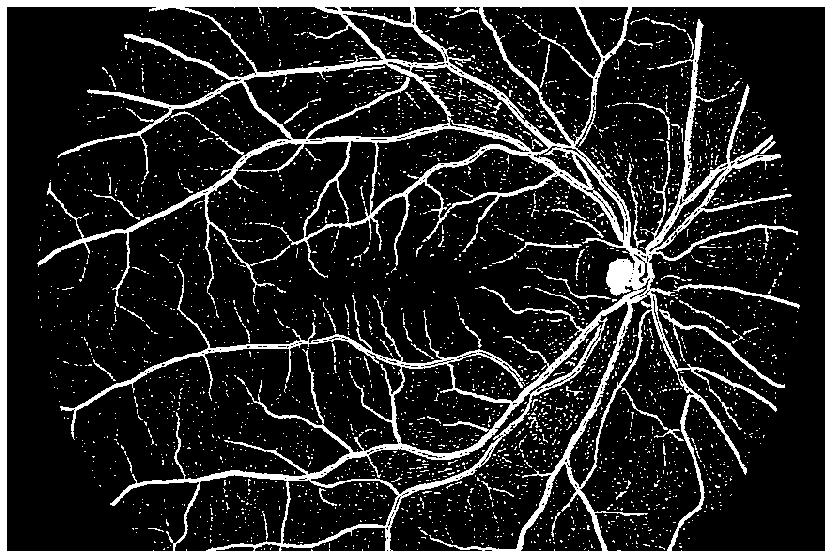

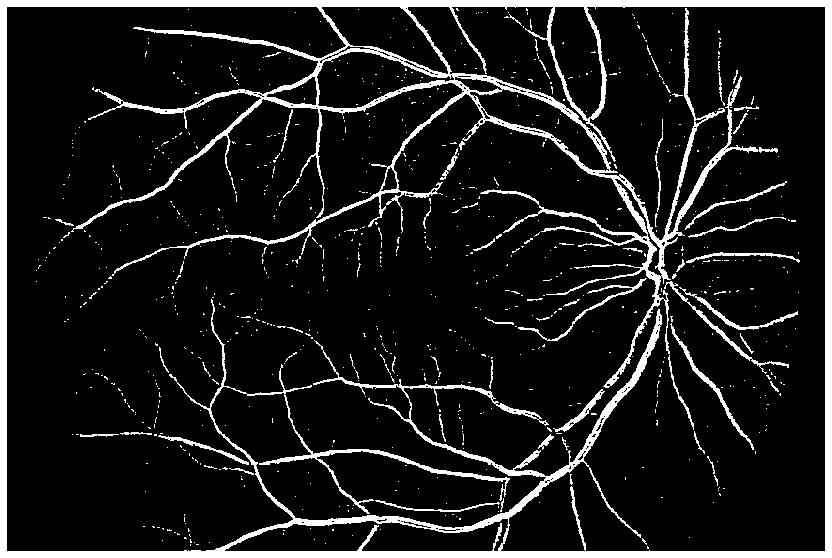

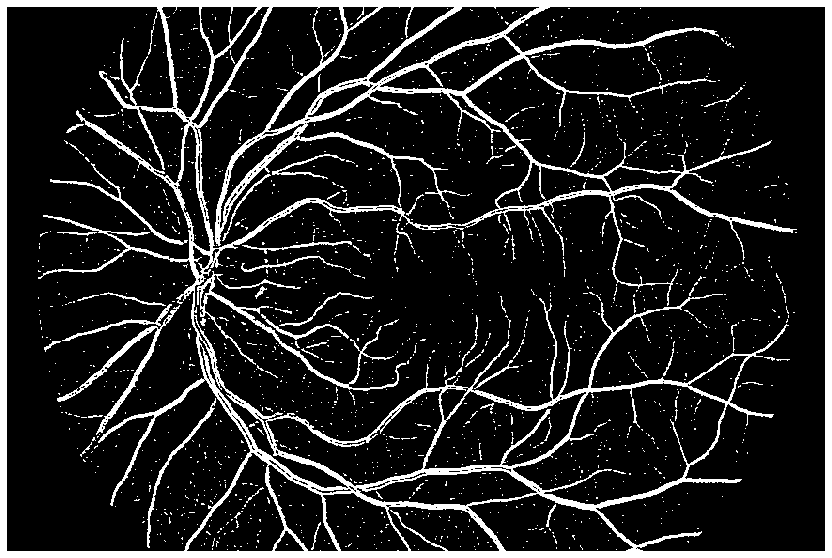

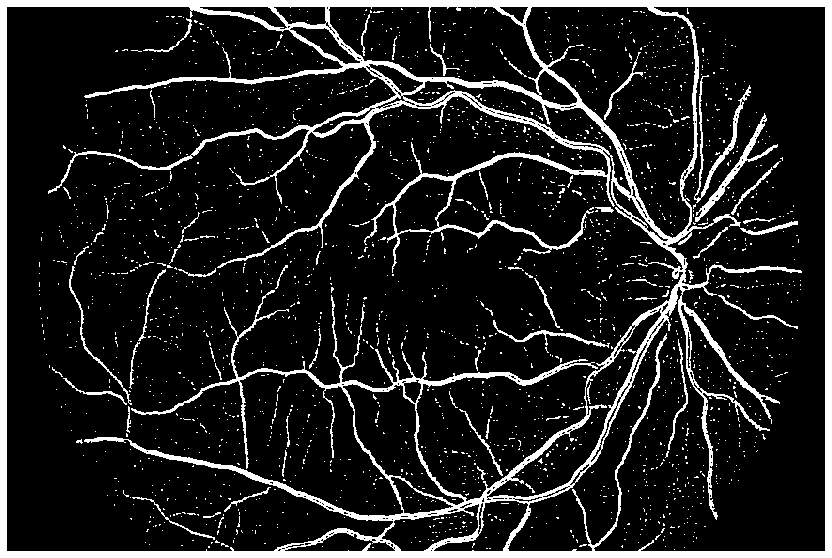

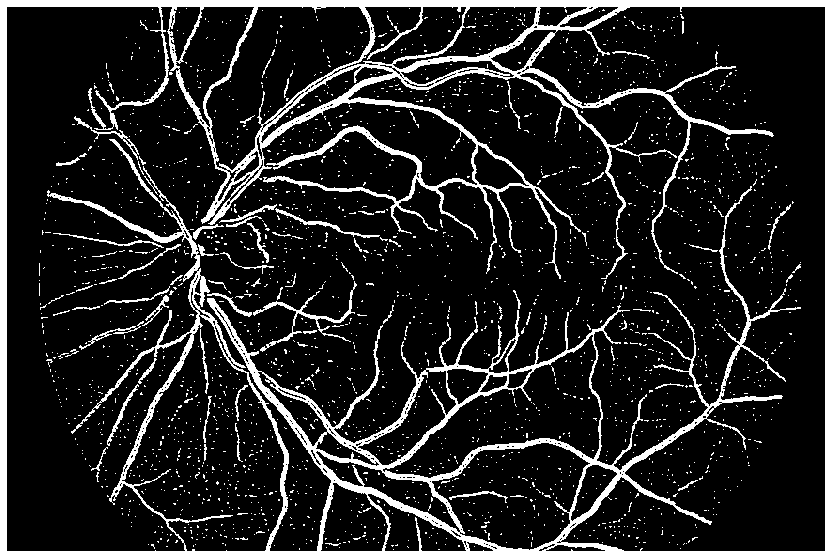

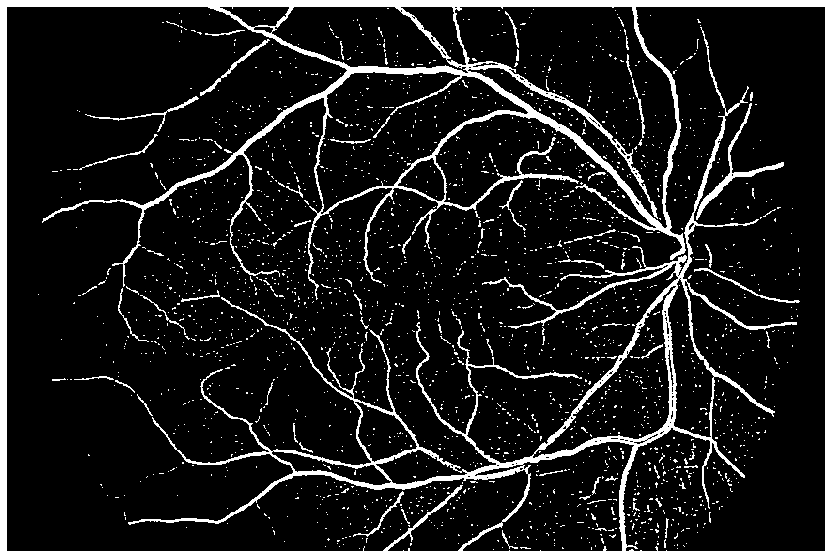

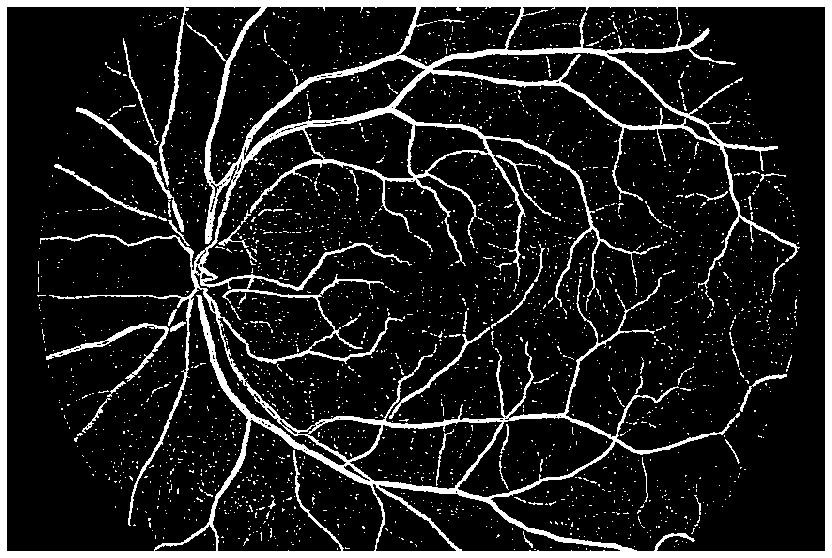

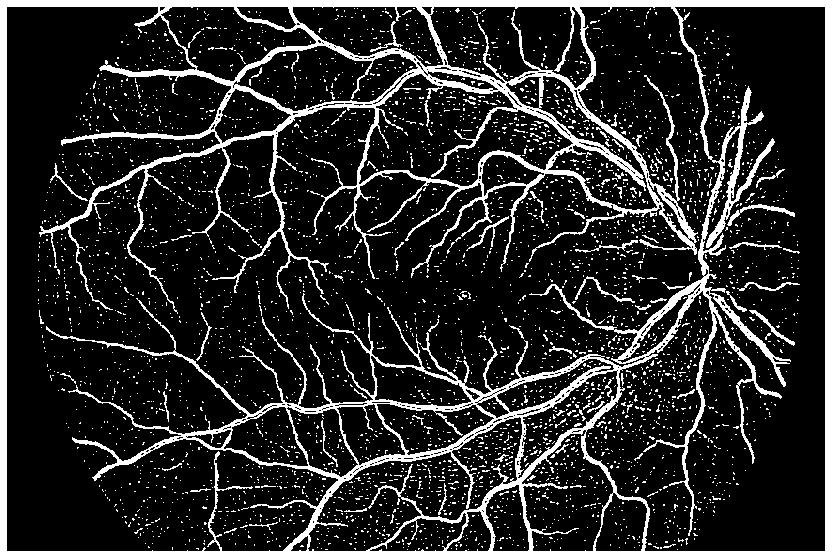

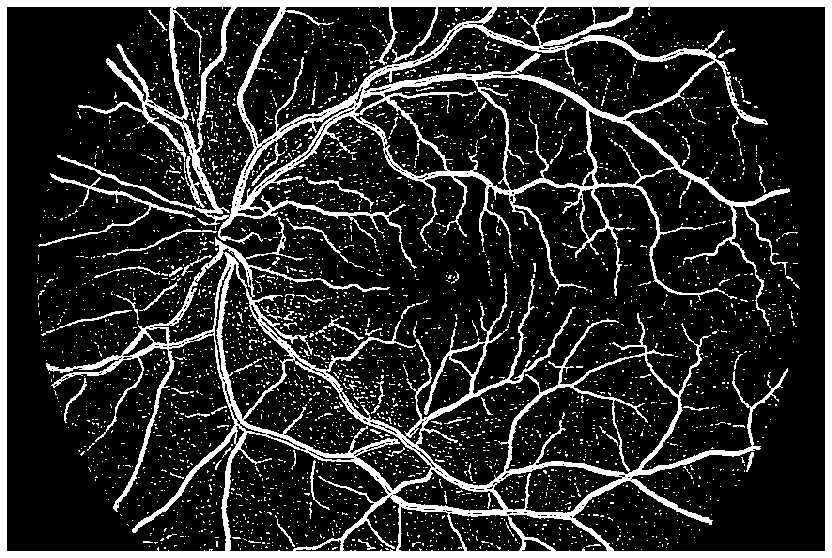

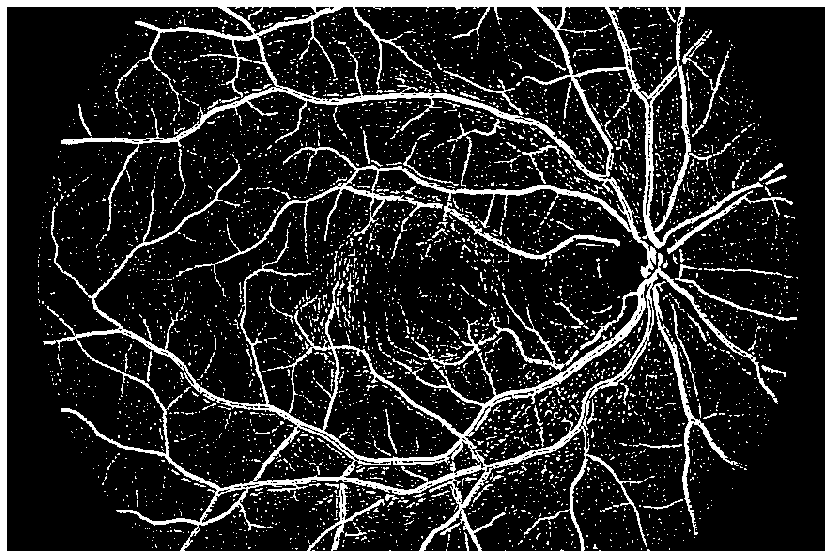

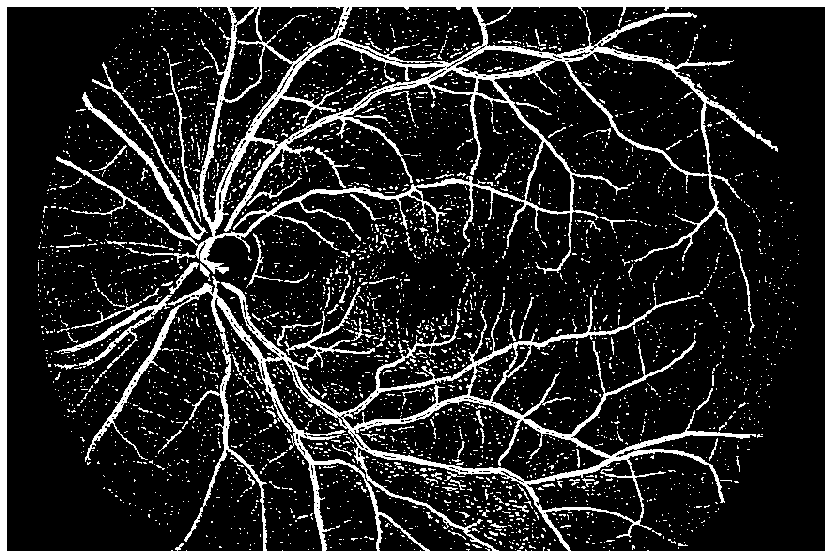

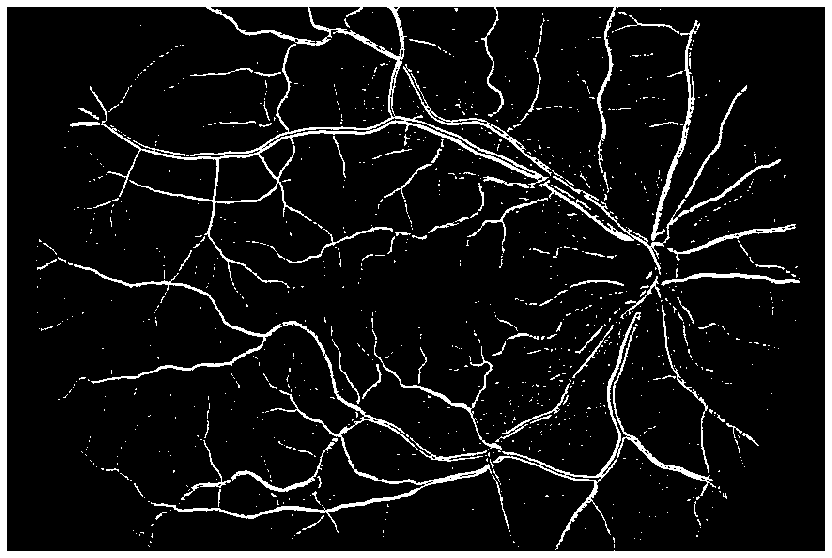

In [25]:
# wyświetl wynik na nowych obrazkach
avg_accuracy = avg_sensitivity = avg_specificity = avg_negative = avg_precision = 0

for k in range(0, len(img_paths) - 3):
    img = readImage(img_paths[k + 3])
    ground_truth = readImage(ground_truth_paths[k + 3])

    data_x, data_y = getImageValuesAsModelData([img], [ground_truth], img_samples_size, 1)
    prediction = model.predict(data_x)

    height, width, depth = img.shape

    comparsion = []
    pixel_img = []

    # zamień piksele na obrazki wynikowe
    for i in range(0, height - img_samples_size):  
        row_comparsion = []
        row_pixel = []
        for j in range(0, width - img_samples_size):
            index = (width - img_samples_size) * i + j
            point = np.mean(ground_truth[i][j])

            isVessel = False
            if (point > 50.0):
                isVessel = True

            if(prediction[index][0] < prediction[index][1]):
                # przewidziano naczynie
                row_pixel.append(1)

                if(isVessel == True):
                    row_comparsion.append(np.array([255, 255, 255]))
                else:
                    row_comparsion.append(np.array([255, 0, 0]))
            else:
                # przewidziano tło
                row_pixel.append(0)

                if(isVessel != True):
                    row_comparsion.append(np.array([0, 0, 0]))
                else:
                    row_comparsion.append(np.array([0, 255, 0]))

        comparsion.append(np.array(row_comparsion))
        pixel_img.append(np.array(row_pixel))

    acc, sen, spec, neg, prec = countMetrics(data_y, prediction)
    
    avg_accuracy += acc
    avg_sensitivity += sen
    avg_specificity += spec
    avg_negative += neg
    avg_precision += prec

    print("--------" + " Wyniki dla zbioru nr " + str(k) + " --------")
    print("Accuracy: " + str(acc))

    print("Sensitivity: " + str(sen))
    print("Specificity: " + str(spec))

    print("Negative predictive value: " + str(neg))    
    print("Precision: " + str(prec))

    comparsion = np.array(comparsion)
    pixel_img = np.array(pixel_img)

    plt.figure(figsize=(20,10))

    plt.subplot(1, 1, 1)
    plt.axis('off')
    plt.imshow(comparsion)
    plt.savefig("results/cnn/cnn-compare-" + str(k + 3) + '.png', bbox_inches='tight')

    plt.subplot(1, 1, 1)
    plt.axis('off')
    plt.imshow(pixel_img, cmap="gray")
    plt.savefig("results/cnn/cnn-result-" + str(k + 3) + '.png', bbox_inches='tight')

    k += 1

print("Średnie wyniki dla tego rozwiązania")
print("średnie accuracy: " + str(avg_accuracy/k))
print("średnie sensitivity: " + str(avg_sensitivity/k))
print("średnie specificity: " + str(avg_specificity/k))
print("średnie negative predictive value: " + str(avg_negative/k))
print("średnie precision: " + str(avg_precision/k))
